## Exploration of KernelSHAP with binary MNIST

**Function        : Exploration of KernelSHAP with binary MNIST**<br>
**Author          : Team DIANNA**<br>
**Contributor     :**<br>
**First Built     : 2021.11.24**<br>
**Last Update     : 2021.11.30**<br>
**Library         : os, numpy, matplotlib, tensorflow, keras, shap**<br>
**Description     : In this notebook we test XAI method KernelSHAP using trained binary MNIST model.**<br>
**Return Values   : Shapley scores**<br>
**Note**          : We use shap library, which is the original implementation by the author of "SHAP" paper, to perform KernelSHAP.<br>

In [19]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import numpy as np
import shap
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import warnings

In [2]:
# prepare binary mnist dataset

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# check the shape of train and test sets
print("Before filtering")
print("training set shape", x_train.shape)
print("training set label shape", y_train.shape)
print("testing set shape", x_test.shape)
print("testing set label shape", y_test.shape)
# get all the images labelled "0" and "1" (binary filtering)
label_a = 0
label_b = 1
x_train_binary = x_train[(y_train == label_a) | (y_train == label_b),:]
y_train_binary = y_train[(y_train == label_a) | (y_train == label_b)]
x_test_binary = x_test[(y_test == label_a) | (y_test == label_b),:]
y_test_binary = y_test[(y_test == label_a) | (y_test == label_b)]
# check the shape of train and test sets after filtering
print("After filtering")
print("training set shape", x_train_binary.shape)
print("training set label shape", y_train_binary.shape)
print("testing set shape", x_test_binary.shape)
print("testing set label shape", y_test_binary.shape)

Before filtering
training set shape (60000, 28, 28)
training set label shape (60000,)
testing set shape (10000, 28, 28)
testing set label shape (10000,)
After filtering
training set shape (12665, 28, 28)
training set label shape (12665,)
testing set shape (2115, 28, 28)
testing set label shape (2115,)


In [3]:
# define basic parameters of training
batch_size = 128
num_classes = 2
epochs = 2

# preprocess training and testing sets
if K.image_data_format() == 'channels_first':
    x_train_binary = x_train_binary.reshape(x_train_binary.shape[0], 1, img_rows, img_cols)
    x_test_binary = x_test_binary.reshape(x_test_binary.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_binary = x_train_binary.reshape(x_train_binary.shape[0], img_rows, img_cols, 1)
    x_test_binary = x_test_binary.reshape(x_test_binary.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train_binary = x_train_binary.astype('float32')
x_test_binary = x_test_binary.astype('float32')
x_train_binary /= 255
x_test_binary /= 255
print('x_train_binary shape:', x_train_binary.shape)
print(x_train_binary.shape[0], 'train samples')
print(x_test_binary.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_binary = keras.utils.to_categorical(y_train_binary, num_classes)
y_test_binary = keras.utils.to_categorical(y_test_binary, num_classes)

x_train_binary shape: (12665, 28, 28, 1)
12665 train samples
2115 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

2021-12-07 15:15:00.237425: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-07 15:15:00.238494: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-07 15:15:00.241535: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
model.fit(x_train_binary, y_train_binary,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_binary, y_test_binary))
score = model.evaluate(x_test_binary, y_test_binary, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2021-12-07 15:15:03.368730: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-07 15:15:03.369309: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304005000 Hz


Epoch 1/2
99/99 [==============================] - 23s 223ms/step - loss: 0.7138 - accuracy: 0.4883 - val_loss: 0.6590 - val_accuracy: 0.8851
Epoch 2/2
99/99 [==============================] - 20s 206ms/step - loss: 0.6537 - accuracy: 0.7132 - val_loss: 0.6017 - val_accuracy: 0.9570
Test loss: 0.6016778349876404
Test accuracy: 0.9569739699363708


skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


(-0.5, 27.5, 27.5, -0.5)

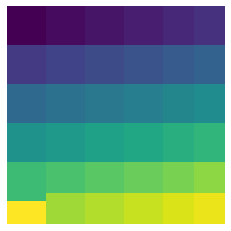

In [38]:
# Create segmentation to explain by segment, not every pixel
segments_slic = slic(x_test_binary[0,:,:,:], n_segments=30, compactness=30, sigma=3)

plt.imshow(segments_slic)
plt.axis('off')

In [39]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    
    if background is None:
        background = image.mean((0, 1))
        
    # Create an empty 4D array
    out = np.zeros((zs.shape[0], 
                    image.shape[0], 
                    image.shape[1], 
                    image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i, :, :, :] = image
        for j in range(zs.shape[1]):
            if zs[i, j] == 0:
                out[i][segmentation == j, :] = background
    return out

# define a model runner
def f(z):
    return model.predict(
        mask_image(z, segments_slic, x_test_binary[0,:,:,:], 2))

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

(-0.5, 27.5, 27.5, -0.5)

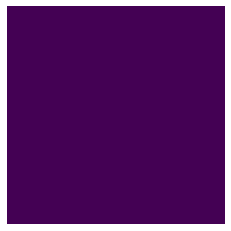

In [40]:
masked_images = mask_image(np.zeros((1,50)), segments_slic, x_test_binary[0,:,:,:], 2)

plt.imshow(masked_images[0][:,:, 0])
plt.axis('off')

In [41]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=100) # runs VGG16 1000 times

  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
predictions = model.predict(np.expand_dims(x_test_binary[0,:,:,:].copy(), axis=0))
top_preds = np.argsort(-predictions)

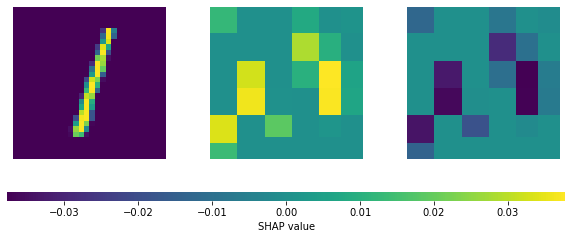

In [43]:
# Visualize the explanations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
inds = top_preds[0]
axes[0].imshow(x_test_binary[0,:,:,:])
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    #axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(x_test_binary[0,:,:,:], alpha=0.15)
    im = axes[i+1].imshow(m, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

### Note that the network is not completely trained due to the ow performance of hardware. It demonstrates that the kernel explainer in shap works with tf models. 